# Measuring, evaluating, and benchmarking team's success
In this exercise, I examine a number of headline team performance measures of National Hockey League (NHL). The goal of the exercise is to examine usefulness of the traditional measure of team performance translates to success of the team (win totals).

I ask the following headline questions: 

1. What are the components to look for in predicting team's future performace?
2. How headline performance measures are calculated and how they differ
3. Are these baseline predictor have equal or better predictive power than betting lines/odds, thus represeting sufficient information as in efficient market (hypothesis)?
4. Say that these headline indicators (in real-time) are the only measure to predict the outcome, which measures tend to best estimate the outcome of the next game?

This analysis series is based on the data processing flow that I created, from [my NHL Analytics Github repository](https://github.com/justinjoliver/NHL-Analytics).

# Setting up the data
Details on how the play/game level data are pulled and processed are saved in [my Github repository](https://github.com/justinjoliver/NHL-Analytics).

# Data features to consider when creating metrics

Note that 0: loss; 0.5: overtime; 1: outright win

**Goals for and Goals against**
* Level (aggregation)
* Differential: Goals for - Goals Against
* Ratio: Goals for / Goals Against

**Possession change** 
* Level sum (aggregation)

**Penalty**
* Difference: pim own - pim opponent
* Difference: power play count - penalty count (this is less needed with pim information available)

**Range**
* Season summary (to date for real-time evaluations)
* Rolling summary (to evaluate vintage performance at-the-time)
* Recency rolling summary (to evaluate past specific windows)

Priority measure: headline measure best serves predictor of performance.
* Pythagorean Expectation
* [Corsi measurement](https://medium.com/hockey-stats/advanced-hockey-stats-101-corsi-part-1-of-4-29d0a9fb1f95)
* pairwise predictor, use in [college hockey](https://www.uscho.com/faq/pairwise-rankings-explanation/) to combine both stregth of records and strength of schedule.


# Corsi & Fenwick

The [Corsi](https://en.wikipedia.org/wiki/Corsi_(statistic)) measure compares shots made by own team and shots made by its opponents

* Corsi For (CF) = Shot attempts for at even strength: Shots + Blocks + Misses
* Corsi Against (CA) = Shot attempts against at even strength: Shots + Blocks + Misses
* Corsi (C) = CF - CA
* Corsi For % (CF%) = CF / (CF + CA)

The [Fenwick](https://en.wikipedia.org/wiki/Fenwick_(statistic)) measure is similar, in that

$Fenwick = (Shots^{for} + Shots^{for}_{missed}) – (Shots^{against} + Shots^{against}_{missed})$

# Pythagorean Expectation (PE)

Pythagorean Expectation is an aggregate headline measure commonly used in team sports, establishing expectations of teams success based on how much they can score and how much they can defend opponents from scoring. 

Historically, the masure has been extremely successful in benchmarking teams sucess during the regular seasons and during the Stanely Cup Playoff. My [dashboard](https://public.tableau.com/app/profile/justin.l.1253/viz/NHL-PythagoreanExpectation/Dashboard2) shows the historical performance of each team and the season PE going back to 1917.

Up-to-date performance measurement of team's performance,

$\frac{(Goals \; for)^2}{(Goals \; for)^2 + (Goals \; against)^2}$

Measure of entire season as a reference

# Rating Percentage Index (RPI)

More direct measure to compare is to have weighted grade by incorporating opponents record and opponents' opponents record (not ncessarily head-to-head).

1. [Rating Percentage Index](https://en.wikipedia.org/wiki/Rating_percentage_index#:~:text=The%20rating%20percentage%20index%2C%20commonly,and%20its%20strength%20of%20schedule.)
You can be creative, such as weighting home/away game wins; but we use a simple formula

$RPI = (WP * 0.25) + (OWP * 0.50) + (OOWP * 0.25)$

In [34]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FixedFormatter, FixedLocator
plt.rcParams.update({'font.size': 16})

str_dirc = '/Google Drive/Learning/sports/nhl/';
# Connect to my driver from google CoLab
#from google.colab import drive
#drive.mount('/content/drive')

# import relevant functions
str_dir_sourceCode = "/GitHub/NHL-Analytics/src/measurement"
exec(open(str_dir_sourceCode + "/measurement_teamSuccess.py").read())

# Pull the latest data for process
df_box = pd.read_csv(str_dirc + "2021_02_box.csv", parse_dates = ['gameDate'], index_col = 'gameIdx')

df_box_exnt = df_unpack(df_box)
df_box_exnt.columns

# Calculate Corsi and Fenwick
df_box_exnt = df_metrics(df_box_exnt)
df_box_exnt.tail(10)

# Aggregate up for team-level statistics
dfteams = df_box_exnt.groupby(['team_tri_for'])\
    .agg(
        {
            "fenwick_lvl":"sum",
            "corsi_lvl":"sum",
            "rpe":"last",
            "rwin":"last",
            "rgame":"last"
        }
    )
dfteams.sort_values(by = ["rwin","fenwick_lvl", "corsi_lvl"], inplace = True)
# Join with season-pythagorean expectation
#dfteams = dfteams.join(df_pe_season)

# Normalize KPIs for measurement comparison
dfteams['wp'] = dfteams.rwin / dfteams.rgame
dfteams['kpi_corsi'] = kpinorm(dfteams.corsi_lvl)
dfteams['kpi_fenwick'] = kpinorm(dfteams.fenwick_lvl)
dfteams['kpi_pe'] = kpinorm(dfteams.rpe)

# Evaluate simple correlation between the kpi's
dfteams.corr()

dfteams


Because we do not have 'season' level, we need rolling (cumulative measure) of expectation

## Rolling Pythagorean Expectation(rPE)

Imagine teams climbing up (hopefully) the trend line as season progress

In [ ]:
# Coefficient estimates from 2010-2020

beta_pyth_old = 0.00809623 * 100
alpah_pyth_old = 0.042901
x_starting = 0.3
x_end = x_starting + 0.45
y_starting = (x_starting) * beta_pyth_old + alpah_pyth_old
y_end = (x_end) * beta_pyth_old + alpah_pyth_old

# Plot
plt.figure(figsize=(12,8))
plt.scatter(df_box_exnt['rpe'], 
            df_box_exnt['rwin']/82, 
            c = df_box_exnt['gameDate_for'], 
            cmap ='viridis')
plt.xlabel("Pythagorean Expectation - Scaled goals for/against")
plt.ylabel("Win percentage (of 82 games)")
plt.title("Pythagorean Expectation (P.E.):\nIn-season progression & Season equilibrium")

#plt.colorbar()
cbar = plt.colorbar()
cbar.ax.set_yticklabels(['Start', '', '','','','','','', 'End'])
cbar.set_label('Season progression', rotation=270)

# What the curve is for 2010 - 2020 Regular seasons
plt.annotate('P.E. (\'10 - \'20)', xy=(x_starting, y_starting),
             xycoords='data',
             xytext=(x_end, y_end),
             textcoords='data',
             arrowprops=dict(arrowstyle= '<|-|>',
                             color='red',
                             lw=3.5,
                             ls='--')
           )
# Equilibrium line to show progression
plt.annotate('', xy=(0.6, 0),
             xycoords='data',
             xytext=(0.5, 34/82),
             textcoords='data',
             arrowprops=dict(arrowstyle= '<|-',
                             color='magenta',
                             lw=2.5,
                             ls=':')
           )
# Final Pythagorean expectation line for the season
plt.annotate('P.E. (\'21)', 
             xy=(dfteams.iloc[0,:]["rpe"], 
                 dfteams.iloc[0,:]["rwin"]/82),
             xycoords='data',
             xytext=(dfteams.iloc[-1,:]["rpe"],
                     dfteams.iloc[-1,:]["rwin"]/82),
             textcoords='data',
             arrowprops=dict(arrowstyle= '<|-|>',
                             color='blue',
                             lw=3.5,
                             ls='--')
           )
plt.savefig("plot_pe_progress.png")

As season progress (dark to light) teams find their season expected performance (equilibrium). Question is - when and where each team will reach at the end? are seasons decided before All-star period? One way to check is to see how they change over time, specifically in last $n$ games.

The median estimates of the correlation above suggests that teams are more likely to win if their recent performance has been better than they did in previous period (positive changes in rPE). 

This may sound obvious, but this theoretically hints a weak evidence of 'hot streak' - where teams that are starting to perform better tends to continue to perform better (leading to multiple wins in a row).

One factor to account for, an argument against the importance of 'hot streak,' is the performance of extrema's. If certain number of teams are performing extremely poorly and others extremely well, then the $rPE$ and $ΔrPE$ measure would naturally sckewed towards loss/win, respectively. A good example would be teams that suffer since the beginning of the season and continues to struggle throughout the season. This is well documented in the expectation of outcome as well, in [my evaluation of betting market](https://medium.com/@thinkingjustin/better-than-puck-flips-money-line-and-market-expectation-in-nhl-91786fcf6f01).

$\Delta rPE$ shows a stronger relationship with the win at the time (recency) than cumulative win (an overall success), and vice versa with $rPE$. Also, the correlation with $win$ between $\Delta rPE$ and $rPE$ are almost identical.

Above observations hint a couple takeaways
* Recency of performance does not necessarily provides a better predictor than the cumulative representation of team's success up to the time → Argument against the hot-streak.
* Recency of performance provides a better predictor in real-time than longer out horizon → This also changes as the season matures.

rPE can be used as a proxy measure of 'regime' or 'hot streak' - if there is such a thing in sports (hint, hint - this is a hot topic. See [one of the recent studies](https://www.nber.org/papers/w29468)). In technicality, without going off topic, the regime can be confused with random probability in local regime (finite monte hall problem), not a large-sample long duration game. 

The changes in variability over time is something we can check - if those hot streaks tend to 

# Head-to-head: Measurements of Opponents' Opponents

Measure starts with comparing 
1. Head to Head performance
2. Match records against common opponents
3. Majority rule of performance against the common opponents


In [35]:
# drop the first game, 
df_box_exnt.loc[df_box_exnt.gameDate_del_against.notnull(), :].head(3)
dff = df_box_exnt.copy(deep = True)

time_games_all = np.sort(dff.gameDate_for.unique()); # by date existing

# Capture the last date.
iter_time = time_games_all[-1];

# NOTE: while it may be exciting to compute the measure in real time, it takes
#   some time to compute it all. I focus on looking at upto the latest available
#   data

dff_h2h_com = df_gen_h2h_common(dff, iter_time)

### (a) Pairwise - head to head win count
Head to head win count rank

In [36]:
# own success
df_own = df_box_exnt \
    .groupby(['team_tri_for']) \
    .agg(
        {
            "rwin":"last",
            "rgame":"last"
        }
    ).reset_index()
df_own["wp_own"] = df_own.rwin / df_own.rgame
df_own.set_index("team_tri_for", inplace = True)

# Opponents' success, accumulated
df_ow = df_box_exnt \
    .groupby(['team_tri_for', 'team_tri_against']) \
    .agg(
        {
            "rwin_oppo":"last",
            "rgame_oppo":"last",
        }
    ).reset_index().groupby(['team_tri_for']) \
    .agg(
        {
            "rwin_oppo":"sum",
            "rgame_oppo":"sum",
        }
    ).reset_index()
df_ow["wp_ow"] = df_ow.rwin_oppo / df_ow.rgame_oppo
df_ow.set_index("team_tri_for", inplace = True)

# Opponents common opponents success
idx_h2h_pivot = 'team_tri_for_ow'
df_oow = dff_h2h_com.groupby([idx_h2h_pivot]) \
    .agg(
        {
            'game_won_h2h_ow':'sum', 
            'game_played_h2h_ow':'sum'
        }
    ).reset_index()
df_oow["wp_oow"] = df_oow.game_won_h2h_ow / df_oow.game_played_h2h_ow
df_oow.set_index(idx_h2h_pivot, inplace = True)

df_own = df_own.join(df_ow)
df_own = df_own.join(df_oow)

df_own['rpi'] = (df_own.wp_own * 0.25) \
                + (df_own.wp_ow * 0.5) \
                + (df_own.wp_oow * 0.25) 
df_own.drop(columns = ['rgame', 'rwin', 
                        'rwin_oppo', 'rgame_oppo',
                        'game_won_h2h_ow', 'game_played_h2h_ow'
                    ], 
            inplace = True)
df_own.sort_values(by = 'rpi')

dfteams = dfteams.join(df_own)

In [ ]:
dff_h2h_com_win = dff_h2h_com\
    .groupby(['team_tri_for_ow', 'team_tri_for_oow']) \
    .agg(
        {
            'game_won_h2h_ow':'sum', 
            'game_played_h2h_ow':'sum',
            'game_won_h2h_oow':'sum', 
            'game_played_h2h_oow':'sum'
        }
    )
# for each opponent, compare who has winning record as common opponent
#   I use win ratio
dff_h2h_com_win['h2h_win'] = (\
    (dff_h2h_com_win.game_won_h2h_ow / dff_h2h_com_win.game_played_h2h_ow) > \
    (dff_h2h_com_win.game_won_h2h_oow / dff_h2h_com_win.game_played_h2h_oow)
) * 1
# For each team, count how many opponents the team has winning record against 
rank_pairwise_win = dff_h2h_com_win.groupby(['team_tri_for_ow']) \
                    .agg({'h2h_win':'sum'}) \
                    .sort_values(by = 'h2h_win', ascending = False)
rank_pairwise_win.columns = ['pairwise_win']

# Here the rank can even be more continuous (how much they win instead of count in games)

# Join with the existing team stats
dfteams = dfteams.join(rank_pairwise_win)
# Normalize
dfteams['kpi_pairwise']  = kpinorm(dfteams.pairwise_win)
dfteams['kpi_rpi']  = kpinorm(dfteams.rpi)
dfteams['kpi_wp']  = kpinorm(dfteams.wp)

dfteams['Final'] = dfteams\
    .sort_values(by = 'kpi_wp', ascending = False) \
    .reset_index().index + 1
dfteams['Final']  = kpinorm(dfteams.wp)

Compare with pythagorean expectation

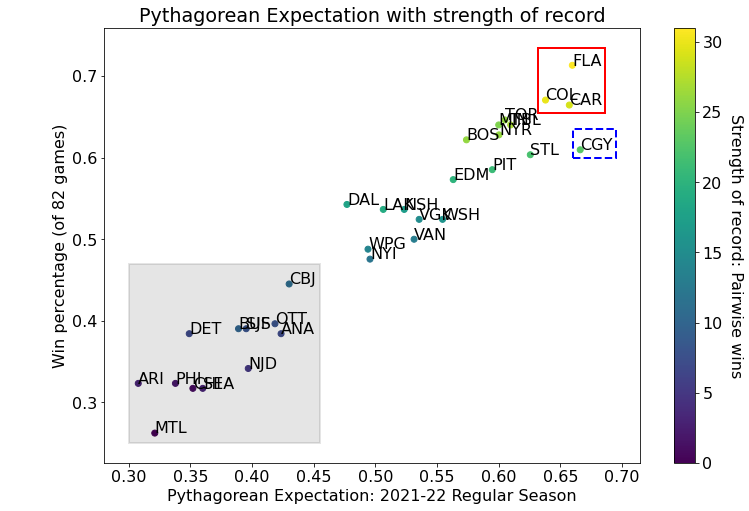

In [105]:
# Plot
plt.figure(figsize=(12,8))

plt.scatter(dfteams['rpe'], dfteams['wp'], c = dfteams['pairwise_win'])


cbar = plt.colorbar()
cbar.set_label('Strength of record: Pairwise wins', 
                rotation = 270, labelpad = 20)

plt.xlabel("Pythagorean Expectation: 2021-22 Regular Season")
plt.ylabel("Win percentage (of 82 games)")
plt.title("Pythagorean Expectation with strength of record")

for i, txt in enumerate(dfteams.index):
    plt.annotate(txt, (dfteams['rpe'][i], dfteams['wp'][i]))



# point out the outlier
emph1 = plt.Rectangle((0.3, 0.25), 0.155, 0.22, 
                      facecolor="black", alpha = 0.1, ec = 'k', lw=2)
emph2 = plt.Rectangle((0.632, 0.655), 0.054, 0.08, facecolor="none", ec = 'r', lw=2)
emph3 = plt.Rectangle((0.66, 0.6), 0.035, 0.035, facecolor="none", ec = 'b', lw=2,
                      linestyle = '--')
ax = plt.gca()

ax.add_patch(emph1)
ax.add_patch(emph2)
ax.add_patch(emph3)

# add pythagorean expectation calculation - 1978 - 2020
plt.annotate('Equilibrium', xy=(0.2, 0.2),
             xycoords='data',
             xytext=(0.3, 0.7),
             textcoords='data',
             arrowprops=dict(arrowstyle= '<|-|>',
                             color='red',
                             lw=3.5,
                             ls='--')
           )

plt.savefig("plot_rankCompare.png")

In [447]:
dfteams.to_csv("2021_02_Full_TeamPerformance.csv")

In [87]:
str_dir_data = "/Google Drive/Learning/sports/nhl/"
dfteams = pd.read_csv(str_dir_data + "2021_02_Full_TeamPerformance.csv")
dfteams.set_index('team_tri_for', inplace = True)

In [ ]:
iterplot = 1
# Those who perform less than anticipated by straight measure
group_1 = ['LAK', 'NJD', 'VGK', 
           'BOS', 'CGY', 'SEA',
           'WSH'
           ]
templot = dfteams[dfteams.index \
                    .isin(group_1)]
# Dataframe stack
dfteams_plot = templot[['kpi_corsi', 'kpi_fenwick', 
                        'kpi_pe', 'kpi_pairwise', 
                        'kpi_rpi', 'kpi_wp', 'Final']].stack()
dfteams_plot = dfteams_plot.reset_index() \
    .rename(columns = {"team_tri_for":"team", 
                        "level_1":"measurements", 
                        0:'value'})

fig, ax = plt.subplots(figsize=(8, 9))
# , subplot_kw=dict(ylim=(0.5, 0.5 + 32))
#ax.xaxis.set_major_locator(MultipleLocator(1))
#ax.yaxis.set_major_locator(MultipleLocator(1))

yax2 = ax.secondary_yaxis("right")
# For finding location rank
temp_rank = dfteams_plot[dfteams_plot.measurements == 'Final']
yax2.yaxis.set_major_locator(FixedLocator(temp_rank["value"].to_list()))
yax2.yaxis.set_major_formatter(FixedFormatter(temp_rank["team"].to_list()))

for i, j in dfteams_plot.groupby("team"):
    ax.plot("measurements", "value", "o-", data=j, mfc="w")

ax.invert_yaxis()
ax.set(xlabel="Measurements", 
       ylabel="Normalized Performance Metrics", 
       title="Team performance: \n On-ice production over team success")
ax.set_xticklabels(['Corsi', 'Fenwick', 
                    'P.E.', 'Pairwise', 'R.P.I', 
                    'Win %', 'Final \nRank'])
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1], 
            ['(Worse)\nLow - 0.0', '0.2', 
             '0.4', '0.6', '0.8', '(Better)\nHigh - 1.0'],
       rotation=0)
ax.yaxis.set_label_coords(-0.14, 0.5)
ax.grid(axis="x")
ax.set_ylim(1.025,-0.025)
plt.tight_layout()

plt.savefig(f"plt_finRankCompare_{iterplot}.png")

In [ ]:
iterplot = 2
# Those who perform less than anticipated by straight measure
group_2 = ['NYR', 'COL', 'TBL',
           'MIN', 'STL']
templot = dfteams[dfteams.index \
                    .isin(group_2)]
# Dataframe stack
dfteams_plot = templot[['kpi_corsi', 'kpi_fenwick', 
                        'kpi_pe', 'kpi_pairwise', 
                        'kpi_rpi', 'kpi_wp', 'Final']].stack()
dfteams_plot = dfteams_plot.reset_index() \
    .rename(columns = {"team_tri_for":"team", 
                        "level_1":"measurements", 
                        0:'value'})

fig, ax = plt.subplots(figsize=(8, 9))
# , subplot_kw=dict(ylim=(0.5, 0.5 + 32))
#ax.xaxis.set_major_locator(MultipleLocator(1))
#ax.yaxis.set_major_locator(MultipleLocator(1))

yax2 = ax.secondary_yaxis("right")
# For finding location rank
temp_rank = dfteams_plot[dfteams_plot.measurements == 'Final']
yax2.yaxis.set_major_locator(FixedLocator(temp_rank["value"].to_list()))
yax2.yaxis.set_major_formatter(FixedFormatter(temp_rank["team"].to_list()))

for i, j in dfteams_plot.groupby("team"):
    ax.plot("measurements", "value", "o-", data=j, mfc="w")

ax.invert_yaxis()
ax.set(xlabel="Measurements", 
       ylabel="Normalized Performance Metrics", 
       title="Team performance: \n Team success over on-ice production")
ax.set_xticklabels(['Corsi', 'Fenwick', 
                    'P.E.', 'Pairwise', 'R.P.I', 
                    'Win %', 'Final \nRank'])
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1], 
            ['(Worse)\nLow - 0.0', '0.2', 
             '0.4', '0.6', '0.8', '(Better)\nHigh - 1.0'],
       rotation=0)
ax.yaxis.set_label_coords(-0.14, 0.5)
ax.grid(axis="x")
ax.set_ylim(1.025,-0.025)
plt.tight_layout()

plt.savefig(f"plt_finRankCompare_{iterplot}.png")

In [ ]:
iterplot = 3
# For those
group_3 = ['NYI', 'PIT', 'VAN',
            'ANA', 'WPG', 'EDM'
           ]
templot = dfteams[dfteams.index \
                    .isin(group_3)]
# Dataframe stack
dfteams_plot = templot[['kpi_corsi', 'kpi_fenwick', 
                        'kpi_pe', 'kpi_pairwise', 
                        'kpi_rpi', 'kpi_wp', 'Final']].stack()
dfteams_plot = dfteams_plot.reset_index() \
    .rename(columns = {"team_tri_for":"team", 
                        "level_1":"measurements", 
                        0:'value'})

fig, ax = plt.subplots(figsize=(8, 9))
# , subplot_kw=dict(ylim=(0.5, 0.5 + 32))
#ax.xaxis.set_major_locator(MultipleLocator(1))
#ax.yaxis.set_major_locator(MultipleLocator(1))

yax2 = ax.secondary_yaxis("right")
# For finding location rank
temp_rank = dfteams_plot[dfteams_plot.measurements == 'Final']
yax2.yaxis.set_major_locator(FixedLocator(temp_rank["value"].to_list()))
yax2.yaxis.set_major_formatter(FixedFormatter(temp_rank["team"].to_list()))

for i, j in dfteams_plot.groupby("team"):
    ax.plot("measurements", "value", "o-", data=j, mfc="w")

ax.invert_yaxis()
ax.set(xlabel="Measurements", 
       ylabel="Normalized Performance Metrics", 
       title="Team performance: \n Walled against better teams")
ax.set_xticklabels(['Corsi', 'Fenwick', 
                    'P.E.', 'Pairwise', 'R.P.I', 
                    'Win %', 'Final \nRank'])
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1], 
            ['(Worse)\nLow - 0.0', '0.2', 
             '0.4', '0.6', '0.8', '(Better)\nHigh - 1.0'],
       rotation=0)
ax.yaxis.set_label_coords(-0.14, 0.5)
ax.grid(axis="x")
ax.set_ylim(1.025,-0.025)
plt.tight_layout()

plt.savefig(f"plt_finRankCompare_{iterplot}.png")

In [ ]:
iterplot = 4
# For those
group_4 = ['PHI', 'DET', 'BUF',
           'SJS'
           ]
templot = dfteams[dfteams.index \
                    .isin(group_4)]
# Dataframe stack
dfteams_plot = templot[['kpi_corsi', 'kpi_fenwick', 
                        'kpi_pe', 'kpi_pairwise', 
                        'kpi_rpi', 'kpi_wp', 'Final']].stack()
dfteams_plot = dfteams_plot.reset_index() \
    .rename(columns = {"team_tri_for":"team", 
                        "level_1":"measurements", 
                        0:'value'})

fig, ax = plt.subplots(figsize=(8, 9))
# , subplot_kw=dict(ylim=(0.5, 0.5 + 32))
#ax.xaxis.set_major_locator(MultipleLocator(1))
#ax.yaxis.set_major_locator(MultipleLocator(1))

yax2 = ax.secondary_yaxis("right")
# For finding location rank
temp_rank = dfteams_plot[dfteams_plot.measurements == 'Final']
yax2.yaxis.set_major_locator(FixedLocator(temp_rank["value"].to_list()))
yax2.yaxis.set_major_formatter(FixedFormatter(temp_rank["team"].to_list()))

for i, j in dfteams_plot.groupby("team"):
    ax.plot("measurements", "value", "o-", data=j, mfc="w")

ax.invert_yaxis()
ax.set(xlabel="Measurements", 
       ylabel="Normalized Performance Metrics", 
       title="Team performance: \n Suffered through better opponents")
ax.set_xticklabels(['Corsi', 'Fenwick', 
                    'P.E.', 'Pairwise', 'R.P.I', 
                    'Win %', 'Final \nRank'])
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1], 
            ['(Worse)\nLow - 0.0', '0.2', 
             '0.4', '0.6', '0.8', '(Better)\nHigh - 1.0'],
       rotation=0)
ax.yaxis.set_label_coords(-0.14, 0.5)
ax.grid(axis="x")
ax.set_ylim(1.025,-0.025)
plt.tight_layout()

plt.savefig(f"plt_finRankCompare_{iterplot}.png")

In [ ]:
iterplot = 5
# Those who perform less than anticipated by straight measure

templot = dfteams[~dfteams.index.isin(group_1) &
                  ~dfteams.index.isin(group_2) &
                  ~dfteams.index.isin(group_3) &
                  ~dfteams.index.isin(group_4)
                ]
# Dataframe stack
dfteams_plot = templot[['kpi_corsi', 'kpi_fenwick', 
                        'kpi_pe', 'kpi_pairwise', 
                        'kpi_rpi', 'kpi_wp', 'Final']].stack()
dfteams_plot = dfteams_plot.reset_index() \
    .rename(columns = {"team_tri_for":"team", 
                        "level_1":"measurements", 
                        0:'value'})
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FixedFormatter, FixedLocator

fig, ax = plt.subplots(figsize=(8, 9))
# , subplot_kw=dict(ylim=(0.5, 0.5 + 32))
#ax.xaxis.set_major_locator(MultipleLocator(1))
#ax.yaxis.set_major_locator(MultipleLocator(1))

yax2 = ax.secondary_yaxis("right")
# For finding location rank
temp_rank = dfteams_plot[dfteams_plot.measurements == 'Final']
yax2.yaxis.set_major_locator(FixedLocator(temp_rank["value"].to_list()))
yax2.yaxis.set_major_formatter(FixedFormatter(temp_rank["team"].to_list()))

for i, j in dfteams_plot.groupby("team"):
    ax.plot("measurements", "value", "o-", data=j, mfc="w")

ax.invert_yaxis()
ax.set(xlabel="Measurements", 
       ylabel="Normalized Performance Metrics", 
       title="Team performance: \n Consistent production")
ax.set_xticklabels(['Corsi', 'Fenwick', 
                    'P.E.', 'Pairwise', 'R.P.I', 
                    'Win %', 'Final \nRank'])
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1], 
            ['(Worse)\nLow - 0.0', '0.2', 
             '0.4', '0.6', '0.8', '(Better)\nHigh - 1.0'],
       rotation=0)
ax.yaxis.set_label_coords(-0.14, 0.5)
ax.grid(axis="x")
ax.set_ylim(1.025,-0.025)
plt.tight_layout()

plt.savefig(f"plt_finRankCompare_{iterplot}.png")

# Further thoughts on relative performance - brainstorm

Unlike the college version, in head to head, how do we decide who is clearly better? In head to head comparisons, especially when not many games are played (small sample), it is hard to gauge who is better team head to head.
* Win percentage? (if played more than one game)
* Goals per game? goals against?
* shot / shot blcoked missed

e.g. team 'a' plays team 'x' two times and win once, whereas team 'b' plays the team 'x' once but walk away without a win. is team 'a' clearly better than team 'a'? In these cases, pythagorean expectation can be helpful, or leveraging shot block.

In other cases as well - head to head of clearly better can be most useful with pythagorean expectation.

Idea: use of pythagorean expectation, we can just aggregate all up and evaluate as one point
* In this case, we need a tie-breaker.